In [171]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 5 & 6 - Fall 2019
## Due Tue 23 Nov, 2021, 11:59 pm.
## *Worth two assignments*

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

Next HW: oban the little patch with a Barnes that you implement manually, for k_st=0.5, reproducing the MetPy solution.

Implement a continuous version of the 4-term Blackman-Harris window (Harris et al. 1978) and use this to filter the radar data. Compare to Barnes.

Take the FT of a ray cutting through our little patch. Then, remove the mean and detrend, and show that FT. Then, apply a Blackman-Harris window, take the FT, and look at that spectrum.


**1.** Copy in your setup from HW3, so that you have the radar data, radar locations, and analysis grid available. Use only the tangent plane cartesian system part, and you don't need to include the plots. Take the time to clean up your original code so that it's the minimally necessary set of variables and functions. (•••• points •••••)

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<xarray.Variable (time: 10)>
array([-0.032955,  0.071411,  0.170288,  0.274658,  0.373535,  0.472412,
        0.576782,  0.678406,  0.780029,  0.873413], dtype=float32)
Attributes:
    long_name:      elevation_angle_from_horizontal_plane
    units:          degrees
    standard_name:  beam_elevation_angle
    axis:           radial_elevation_coordinate
    comment:        Elevation of antenna relative to the horizontal plane
<xarray.DataArray 'elevation' (time: 10)>
array([-0.032955,  0.071411,  0.170288,  0.274658,  0.373535,  0.472412,
        0.576782,  0.678406,  0.780029,  0.873413], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2014-06-14T02:14:19 ... 2014-06-14T02:14:19
    azimuth    (time) float32 ...
    elevation  (time) float32 ...
Attributes:
    long_name:      elevation_angle_from_horizontal_plane
    units:          degrees
    standard_name:  beam_elevation_angle
    axis:           radial_elevation_coordinate
    comment:        Elevation of antenn

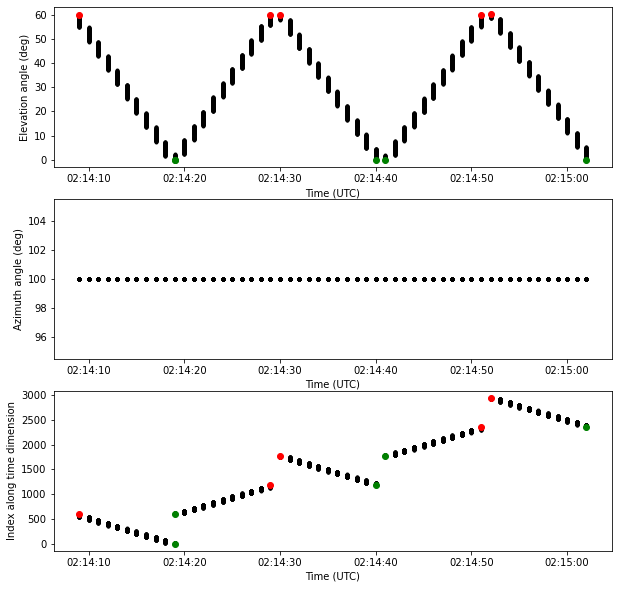

In [151]:
# This also contains corrected code that we discussed in class
# Path of the file and open data set, set our scan index to one
# Desktop/Datafields/Ka2140614021408.RAWPXA9.nc

d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')
scan_idx = 1


# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

In [214]:
# Define the slice for analysis
start_sweep = d.sweep_start_ray_index[scan_idx]
end_sweep = d.sweep_end_ray_index[scan_idx]
sel = slice(start_sweep, end_sweep)
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)
print('Completed Sweep')

#Creating a function to return 1D arrays of the range, azimuth, and elevation
def oned_arrays(d, scan_idx):
    ranges = np.array(d.range)
    azimuths = np.array(d.azimuth[start_sweep.values : end_sweep.values + 1])
    elevations = np.array(d.elevation[start_sweep.values : end_sweep.values + 1])
    return ranges, azimuths, elevations

r, az, el = oned_arrays(d, scan_idx)
print('Completed 1D Arrays')

# Defining the centers to edges from homework one
def centers_to_edges(x):
    nx_edges = x.shape[0]+1
    xe = np.zeros(nx_edges)
    xe[1:-1] = (x[1:] + x[:-1])/2.0
    xe[0] = x[0] - (x[1] - x[0])/2.0
    xe[-1] = x[-1] + (x[-1] - x[-2])/2.0
    return xe
print('Finished defining the centers to edges function')

r_edge = centers_to_edges(r)
e_edge = centers_to_edges(el)
print('Completed transforming centers to edges')

# Defining the edges to centers function
def edges_to_centers(x):
    return (x[1:, 1:] + x[:-1, :-1])/2.0
print('Finished defining the edges to centers function')

#Creating 2d arrays for two arrays: Range vs azimuth and range vs elevation
r_2d, el_2d = np.meshgrid(r_edge, e_edge)
az_2d = np.full_like(el_2d, az[0])
print('Finished creating the 2D arrays')

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count
Completed Sweep
Completed 1D Arrays
Finished defining the centers to edges function
Completed transforming centers to edges
Finished defining the edges to centers function
Finished creating the 2D arrays


In [215]:
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import TangentPlaneCartesianSystem

#Defining the lat, lon, and alt values at the radar
ctrlat = d.latitude.values
ctrlon = d.longitude.values
ctralt = d.altitude.values


#Definging the tangent planes at the radar
radarcoord = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)
X_ECEF, Y_ECEF, Z_ECEF = radarcoord.toECEF(r_2d, az_2d, el_2d)

TPCS = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
X_TPCS, Y_TPCS, Z_TPCS = TPCS.fromECEF(X_ECEF, Y_ECEF, Z_ECEF)

print('Completed Defining Tangent Planes')

#Making the shapes of the arrays the same so we can plot them
X_TPCS.shape = r_2d.shape
Y_TPCS.shape = r_2d.shape
Z_TPCS.shape = r_2d.shape

range_t = np.sqrt(X_TPCS * X_TPCS + Y_TPCS * Y_TPCS)

range_t_ctr = edges_to_centers(range_t)
el_t_ctr = edges_to_centers(Z_TPCS)

print('Shape of the X TPCS Array', X_TPCS.shape)
print('Shape of the Y TPCS Array', Y_TPCS.shape)
print('Shape of the Z TPCS Array', Z_TPCS.shape)

from coordinateSystems import MapProjection
aeqd = MapProjection(projection='aeqd', lon_0=ctrlon, lat_0=ctrlat)
X_AEQD, Y_AEQD, Z_AEQD = aeqd.fromECEF(X_ECEF, Y_ECEF, Z_ECEF)


#Making the planes have the same shapes
X_AEQD.shape = r_2d.shape
Y_AEQD.shape = r_2d.shape
Z_AEQD.shape = r_2d.shape

print('Shape of the X AEQD Array', X_AEQD.shape)
print('Shape of the Y AEQD Array', Y_AEQD.shape)
print('Shape of the Z AEQD Array', Z_AEQD.shape)
print('Finished arrays')

Completed Defining Tangent Planes
Shape of the X TPCS Array (587, 1667)
Shape of the Y TPCS Array (587, 1667)
Shape of the Z TPCS Array (587, 1667)
Shape of the X AEQD Array (587, 1667)
Shape of the Y AEQD Array (587, 1667)
Shape of the Z AEQD Array (587, 1667)
Finished arrays


In [155]:
#Creating the range array
inc = 5
range_arr_start = 9000
range_arr_end = 9500
range_arr = np.arange(range_arr_start, range_arr_end + inc, inc)
print('Finished creating range array')

#Creating the altitude array
alt_arr_start = 2900
alt_arr_end = 3400
alt_arr = np.arange(alt_arr_start, alt_arr_end + inc, inc)
print('Finished creating altitude array')

# Meshing grid together (solution given in class for HW three, I did it wrong originally)
range_arr_2d, alt_arr_2d = np.meshgrid(range_arr, alt_arr)
print('Finished meshing grids')

# New centers to edges to centers function for 2D array, againnnn I did it wrong in HW3 (we shouldnt be surprised at this point)
alt_2darr_ctr = (alt_arr[1:] + alt_arr[:-1])/2.0
range_2darr_ctr = (range_arr[1:] + range_arr[:-1])/2.0

range_2d, alt_2d = np.meshgrid(range_2darr_ctr, alt_2darr_ctr)
print('Finished transforming edges to centers')

Finished creating range array
Finished creating altitude array
Finished meshing grids
Finished transforming edges to centers


In [156]:
from metpy.interpolate import interpolate_to_points

var2interp = d.reflectivity[start_sweep.values : end_sweep.values + 1]
data_stack = np.vstack((range_t_ctr.flatten(), el_t_ctr.flatten())).T
ctrstack = np.vstack((range_2d.flatten(), alt_2d.flatten())).T
print('Finished stacking data to interpert')

# Subsetting the data, from what we talked about in class
space = 1000.0
subset = ((data_stack[:,0] >= range_2darr_ctr.min()-space) & 
          (data_stack[:,0] <= range_2darr_ctr.max()+space) &
          (data_stack[:,1] >= alt_2darr_ctr.min()-space) & 
          (data_stack[:,1] <= alt_2darr_ctr.max()+space))
data_stack = data_stack[subset,:]
data_values = var2interp.data.flatten()[subset]
print('Finished subsetting data')

interp_data = {}

Finished stacking data to interpert
Finished subsetting data


**2.** Configuration of the weighting scheme requires that we know the typical data spacing. Following TD2000, define the data spacing as the distance betweent two radar gates at the maximum range. Use the point in your analysis grid that is farthest from the radar, and then find the maximum spacing in elevation angle at this range. Finally, calculate the difference in linear units between the two radar gates you idenified.

Please provide an answer to these two questions:
- What is the maximum distance from the radar in the objective analysis domain
- What is the spacing between two adjacent data points?

In [229]:
radar_distance = np.sqrt((ctrstack**2).sum(axis=1))
maxdistance = np.argmax(radar_distance)
distance= radar_distance[maxdistance]
print(distance)

max_range, max_alt = ctrstack[maxdistance]

range_distance = range_t_ctr - max_range
alt_distance = el_t_ctr - max_alt
max_alt_idex, max_range_idex = np.unravel_index(np.argmin(np.abs(range_distance*range_distance 
                                                                 + alt_distance * alt_distance)),range_t_ctr.shape)

alt_slice = slice(max_alt_idex, max_alt_idex+2)

distance_range = np.diff(range_t_ctr[alt_slice, max_range_idex])
distance_alt = np.diff(el_t_ctr[alt_slice, max_range_idex])
delta = np.sqrt(distance_range**2 + distance_alt**2)

print('The maximum distance from the radar is',distance)
print('The distance from the points are as follows',dRT, dZT, delta)

10086.898061346708
The maximum distance from the radar is 10086.898061346708
The distance from the points are as follows [-6.06605167] [16.94732372] [18.00024345]


**3.** Below, the function `oban` (for "objective analysis") mimics the call signature of the MetPy `interpolate_to_points` function. Its principal difference is the `weight_func` argument, which takes a function instead of a string describing an interpolation method. Since `weight_func` is passed only the distances, it is necessary to use `partial` to pre-fill the function with any other arguments needed to configure the weight function. The `sample_weights` function below shows how this works.

For this question, your jobs are as follows.

**a.**  Specify a cutoff radius. Based on the last homework assignment, what is a good distance to use as a multiple of the data spacing? Make sure to adjust your set of input data points to cover the distance from edge of the analysis grid.

**b.**  Implement a `barnes` function and then use it with `oban` to calculate an analysis on the target grid. 

**c.**  Calculate a Barnes analysis using MetPy, as in the last assignment, and find the difference (yours - MetPy). They probably won't be the same, even for a sane coniguration of parameters; that's ok.

**d.**  Plot the original data, the two analyses, and the difference.


In [158]:
from scipy.spatial import cKDTree
from functools import partial

def oban(points, values, xi, weight_func, search_radius):

    # Find all points in the vicinity of each analysis location in xi
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    
    analysis = np.zeros(xi.shape[0])
    
    # This is linear (times the typical neighborhood size) in the number of analysis points
    for i, (pt, neighbors) in enumerate(zip(xi, query)):
        data = values[neighbors]
        delta_dist = points[neighbors,:] - pt
        distsq = (delta_dist*delta_dist).sum(axis=1) # sum of squared distances
        w = weight_func(np.sqrt(distsq))
        analysis[i] = (w*data).sum()/w.sum()
    return analysis

def sample_weights(r, value=None):
    return np.zeros_like(r) + value

my_weight_func = partial(sample_weights, value=3.0)
my_test_ranges = np.arange(10.0)
my_test_weights = my_weight_func(my_test_ranges)
print(my_test_weights) # oban will call my_weight_func like so

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [176]:
# Part A
max_dist = 3*delta
delta=max_dist

In [234]:
# Part B
# Defining the functions k star and barnes
k_star = 0.5

def barnes(r, k=None):
    weight = np.exp(-(r*r) / k)
    return weight

# From our notes and the last homework, prefill our weight function with what we learned in class today
k_star1 = 4*delta*delta*k_star
barnes_weight_partial = partial(barnes, k=k_star1)

print('Finished barnes function')

# Call the barnes analysis
barnes_analysis = oban(data_stack, data_values, ctrstack, barnes_weight, search_radius=max_dist)
barnes_analysis.shape = range_2d.shape
print('Finished barnes analysis')

barnes_analysis_points = interpolate_to_points(data_stack, data_values, ctrstack,interp_type='barnes', kappa_star=k_star,
                                               search_radius=maximum_distance)
barnes_analysis_points.shape = range_2d.shape
print('Finished barnes analysis interpolating points')

Barnes_delta = (barnes_analysis - barnes_analysis_points)*10

Finished barnes function
Finished barnes analysis
Finished barnes analysis interpolating points


Completed importing NWS Colortables


<ipython-input-235-7cfdbb3b3ee8>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(range_2d,alt_2d,barnes_analysis,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-235-7cfdbb3b3ee8>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = ax3.pcolormesh(range_2d,alt_2d,barnes_analysis_points,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-235-7cfdbb3b3ee8>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as 

Finished creating plots


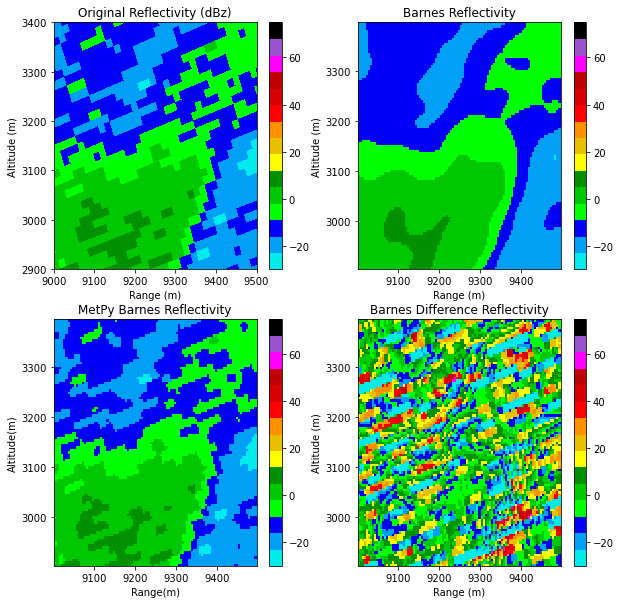

In [235]:
# Part D, plot the functions
#Importing NWS color tables that will match them used by NWS
from metpy.plots import ctables
from matplotlib.colors import Normalize
NWSRef = ctables.registry.get_colortable('NWSReflectivity')
NWSVel = ctables.registry.get_colortable('NWSVelocity')
NWSSW = ctables.registry.get_colortable('NWSSpectrumWidth')
NWSNC = ctables.registry.get_colortable('Carbone42')
print('Completed importing NWS Colortables')


fig = plt.figure(figsize=(10,10)) 

ax1 = fig.add_subplot(221)
im1 = ax1.pcolormesh(range_t,Z_TPCS,reflectivity,cmap=NWSRef,vmin=-30,vmax=75)
ax1.set_ylabel('Altitude (m)')
ax1.set_xlabel('Range (m)')
ax1.set_title('Original Reflectivity (dBz)')
ax1.set_xlim([9000.0,9500.0])
ax1.set_ylim([2900.0,3400.0])
fig.colorbar(im1)

ax2 = fig.add_subplot(222)
im2 = ax2.pcolormesh(range_2d,alt_2d,barnes_analysis,cmap=NWSRef,vmin=-30,vmax=75)
ax2.set_ylabel('Altitude (m)')
ax2.set_xlabel('Range (m)')
ax2.set_title('Barnes Reflectivity')
fig.colorbar(im2)

ax3 = fig.add_subplot(223)
im3 = ax3.pcolormesh(range_2d,alt_2d,barnes_analysis_points,cmap=NWSRef,vmin=-30,vmax=75)
ax3.set_ylabel('Altitude(m)')
ax3.set_xlabel('Range(m)')
ax3.set_title('MetPy Barnes Reflectivity')
fig.colorbar(im3)

ax4 = fig.add_subplot(224)
im4 = ax4.pcolormesh(range_2d,alt_2d,Barnes_delta,cmap=NWSRef,vmin=-30,vmax=75)
ax4.set_ylabel('Altitude (m)')
ax4.set_xlabel('Range (m)')
ax4.set_title('Barnes Difference Reflectivity')
fig.colorbar(im4)

print('Finished creating plots')

**4.** Let's say we want to use another filter from Harris (1978) for our continuous data. Those functions are specified for discrete data, with a hard cutoff after $N$ samples. It would be logical to cut off all our analyses after the same cutoff radius for all data, so that our understanding of the filter function sidelobe behavior from discrete theory can be applied to continous data in an even-handed way.

So, let's repeat the previous question, but now use Blackman, Blackman-Harris and the difference (B-BH). You will need to use Harris (1978) for the mathematical formulation of the windows, as defined below.

**a.**  Implement a `blackman` function and then use it with `oban` to calculate an analysis on the target grid. This is eq. 32 of Harris, but with a minus sign on the second coefficient (-0.50), as in the `scipy.signal.blackman` docs.

**b.**  Implement a `blackman_harris` function and then use it with `oban` to calculate an analysis on the target grid. Use the minimum 4-term Blackman-Harris formulation as in the `scipy.signal.blackmanharris` docs whose coefficients are the -92 dB 4-term window in the table on p. 65 of Harris.

**c.**  Include in this notebook, using a Markdown cell and the $\LaTeX$ functionality, a narrated derivation that shows how you converted the discrete, non-dimensional formulation of the Blackman weight function to a continuous, dimensional form.

**d.**  Make a plot of the weight functions as a function of distance from zero to your cutoff radius.

**e.**  Find the difference (`blackman` - `blackman_harris`).

**f.**  Plot the original data, the two analyses, and the difference.



In [236]:
# Part A
#Define a rectangular window function using Harris paper
def rect(r,r_loc=None):
    r = r-r_loc
    weights = np.ones_like(r)
    return weights
    
rectangle = partial(rect, r_loc=max_dist)
print('Fininished defining rectangle weight')

#Define a blackmanharris window function
def bh(r, r_loc=None):
    r = r - r_loc #distance from analysis loc
    weights = .35875-(.48829 * np.cos(2*np.pi*r/(2*r_loc)))+(.14128 * np.cos(2*(2*np.pi*r/(2*r_loc))))-(.01168 * np.cos(3*(2*np.pi*r/(2*r_loc))))
    return weights

#Use partial to prefill the weight function like we discussed in class
blackman_harris_window = partial(bh, r_loc=max_dist)
print('Finished defining blackman harris window weight')

Fininished defining rectangle weight
Finished defining blackman harris window weight


<span class="ecb">Rectangle window doesn't cut off. -2</span>

##### Part c
$w(n) = a{_0}-a{_1}cos(\frac{2\pi}{N}n)+a{_2}cos(\frac{2\pi}{N}2n)-a{_3}cos(\frac{2\pi}{N}3n)$

###### When talking about it in class and in the paper, the ratio, n/N, is a ratio of distances. Where n is the discrete value, and the largest N being the largest value n can be. Due to this, we can replace that with r/r_loc or r = r-r_loc. Thus: 

$w(r) = a{_0}-a{_1}cos(\frac{2\pi}{2r{_1}}r)+a{_2}cos(\frac{2\pi}{2r{_1}}2r)-a{_3}cos(\frac{2\pi}{2r{_1}}3r)$

Finished defining and plotting the cutoff radius


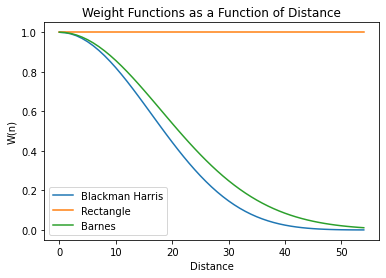

In [237]:
# Part D
#Define the cutoff radius and plot
dis_array = np.arange(0, max_dist)
fig3, ax3 = plt.subplots(1,1)
ax3.plot(dis_array, blackman_harris_window(dis_array), label='Blackman Harris')
ax3.plot(dis_array, rectangle(dis_array), label='Rectangle')
ax3.plot(dis_array, barnes_weight_partial(dis_array), label='Barnes')
ax3.set_xlabel('Distance')
ax3.set_ylabel('W(n)')
ax3.set_title('Weight Functions as a Function of Distance')
ax3.legend()
print('Finished defining and plotting the cutoff radius')

In [238]:
#Part E
#Use the Oban Function to interpolate
rectangle_2 = oban(data_stack, data_values, ctrstack, rectangle,search_radius=max_dist)
rectangle_2.shape = range_2d.shape
bh2 = oban(data_stack, data_values, ctrstack, blackman_harris_window,search_radius=max_dist)
bh2.shape = range_2d.shape
print('Finished retangular analysis')

#Calculate the difference
RBH_diff = bh2-rectangle_2
print('Finished calculating barnes difference analysis')

Finished retangular analysis
Finished calculating barnes difference analysis


<ipython-input-239-7808956e83c7>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(range_2d,alt_2d,rectangle_2,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-239-7808956e83c7>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = ax3.pcolormesh(range_2d,alt_2d,bh2,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-239-7808956e83c7>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3

Finished plotting


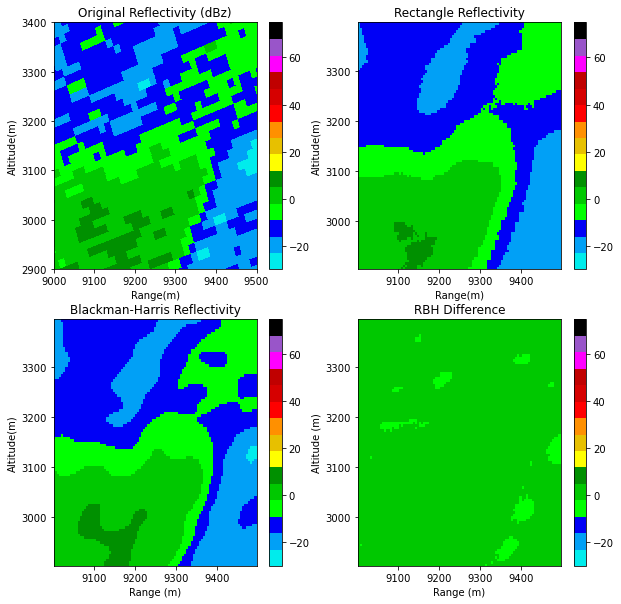

In [239]:
#Plot the original data, the two analyses, and the difference.
fig1 = plt.figure(figsize=(10,10)) 

ax1 = fig1.add_subplot(221)
im1 = ax1.pcolormesh(range_t,Z_TPCS,reflectivity,cmap=NWSRef,vmin=-30,vmax=75)
ax1.set_ylabel('Altitude(m)')
ax1.set_xlabel('Range(m)')
ax1.set_title('Original Reflectivity (dBz)')
ax1.set_xlim([9000.0,9500.0])
ax1.set_ylim([2900.0,3400.0])
fig1.colorbar(im1)

ax2 = fig1.add_subplot(222)
im2 = ax2.pcolormesh(range_2d,alt_2d,rectangle_2,cmap=NWSRef,vmin=-30,vmax=75)
ax2.set_ylabel('Altitude(m)')
ax2.set_xlabel('Range(m)')
ax2.set_title('Rectangle Reflectivity')
fig1.colorbar(im2)

ax3 = fig1.add_subplot(223)
im3 = ax3.pcolormesh(range_2d,alt_2d,bh2,cmap=NWSRef,vmin=-30,vmax=75)
ax3.set_ylabel('Altitude(m)')
ax3.set_xlabel('Range (m)')
ax3.set_title('Blackman-Harris Reflectivity')
fig1.colorbar(im3)

ax4 = fig1.add_subplot(224)
im4 = ax4.pcolormesh(range_2d,alt_2d,RBH_diff,cmap=NWSRef,vmin=-30,vmax=75)
ax4.set_ylabel('Altitude (m)')
ax4.set_xlabel('Range (m)')
ax4.set_title('RBH Difference')
fig1.colorbar(im4)

print('Finished plotting')

**5.** Let's compare the different filters.

**a.** Plot the original data, and using the Barnes filter as a common point of comparison, plot the difference with the other three analyses you calculated.

**b.** Which weighting scheme preserves the greatest detail in fine-scale structure? Illustrate this by discussing a local minimum and a local maximum in the original data vs. the difference fields. Does it make sense in terms of the theoretical response functions we calcualted in the previous homework?

<ipython-input-240-1381726d2085>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(range_2d,alt_2d,barnesrec,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-240-1381726d2085>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = ax3.pcolormesh(range_2d,alt_2d,barnes2bh2,cmap=NWSRef,vmin=-30,vmax=75)
<ipython-input-240-1381726d2085>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated si

Finished plotting


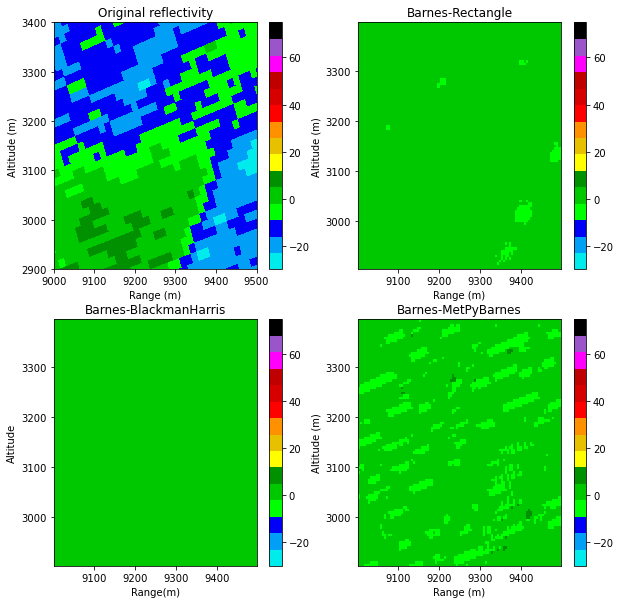

In [240]:
fig2 = plt.figure(figsize=(10,10)) 

barnesrec = barnes_analysis - rectangle_2
barnes2bh2 = barnes_analysis - bh2
barnes23 = barnes_analysis - barnes_analysis_points

ax1 = fig2.add_subplot(221)
im1 = ax1.pcolormesh(range_t,Z_TPCS,reflectivity,cmap=NWSRef,vmin=-30,vmax=75)
ax1.set_ylabel('Altitude (m)')
ax1.set_xlabel('Range (m)')
ax1.set_title('Original reflectivity')
ax1.set_xlim([9000.0,9500.0])
ax1.set_ylim([2900.0,3400.0])
fig2.colorbar(im1)

ax2 = fig2.add_subplot(222)
im2 = ax2.pcolormesh(range_2d,alt_2d,barnesrec,cmap=NWSRef,vmin=-30,vmax=75)
ax2.set_ylabel('Altitude (m)')
ax2.set_xlabel('Range (m)')
ax2.set_title('Barnes-Rectangle')
fig2.colorbar(im2)

ax3 = fig2.add_subplot(223)
im3 = ax3.pcolormesh(range_2d,alt_2d,barnes2bh2,cmap=NWSRef,vmin=-30,vmax=75)
ax3.set_ylabel('Altitude')
ax3.set_xlabel('Range(m)')
ax3.set_title('Barnes-BlackmanHarris')
fig2.colorbar(im3)

ax4 = fig2.add_subplot(224)
im4 = ax4.pcolormesh(range_2d,alt_2d,barnes23,cmap=NWSRef,vmin=-30,vmax=75)
ax4.set_ylabel('Altitude (m)')
ax4.set_xlabel('Range (m)')
ax4.set_title('Barnes-MetPyBarnes')
fig2.colorbar(im4)

print('Finished plotting')

part b: 
After plotting, I belive that the blackman-harris would be the best fit for keeping fine details when plotting. You can find a local minimum in the middle on the right side of the function and a maximum at the bottom on the left hand side. We can relate this back to what we have learned about in class, about the nyquist frequency, and then compare it to the past homework. Thus this gives a good explanation for our data

<span class="ecb">Color map prevents any meaningful diagnosis of the differences.  -1.</span>